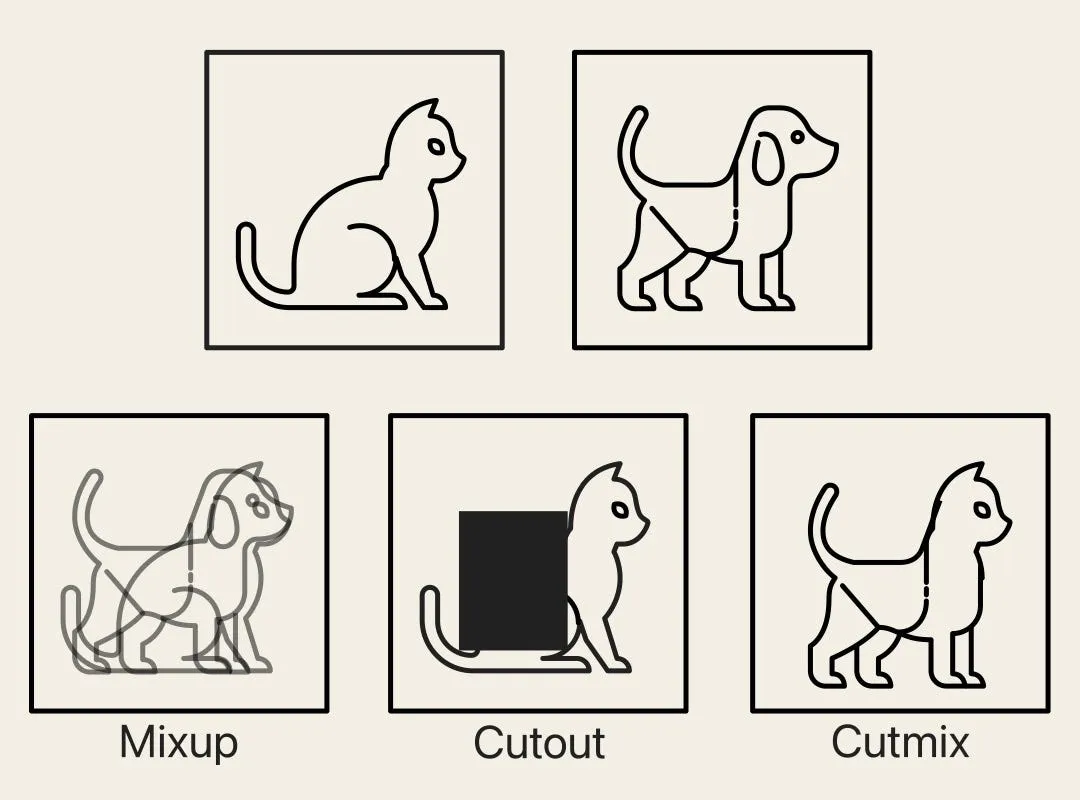

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

data load

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

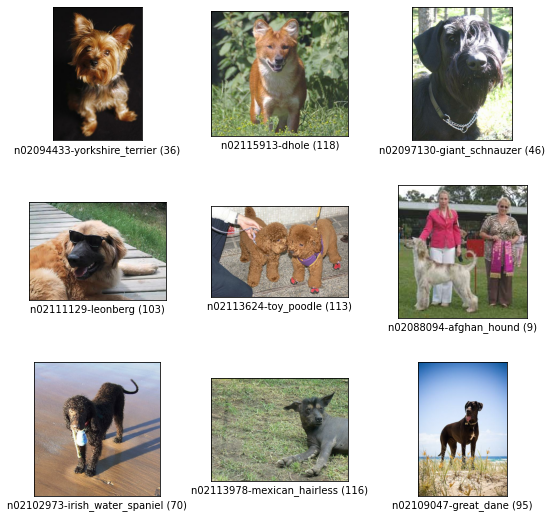

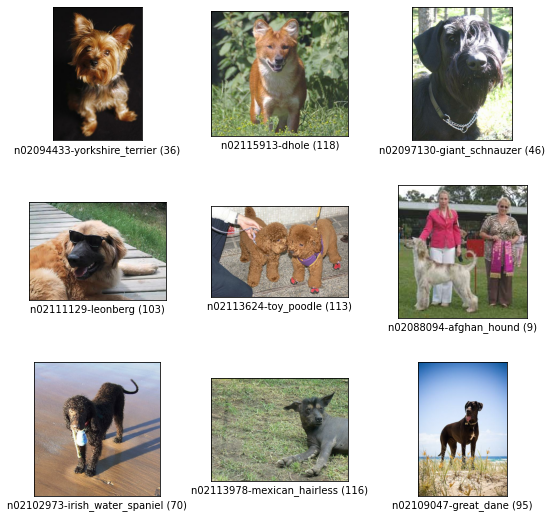

In [5]:
tfds.show_examples(ds_train, ds_info)

data augmentation

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [8]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

apply random aug

In [9]:
# make random augment function
# 추가하기
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

In [10]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

CutMix

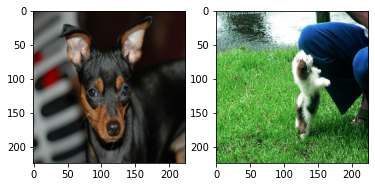

In [13]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [14]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(38, shape=(), dtype=int32) tf.Tensor(80, shape=(), dtype=int32)
y :  tf.Tensor(157, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


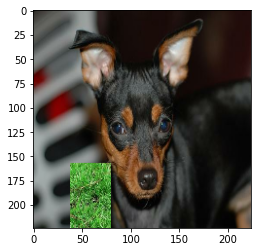

In [15]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [16]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.05608259,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [17]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

Mixup Augmentation

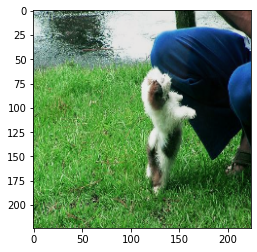

tf.Tensor(
[0.         0.         0.         0.         0.9019474  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.09805262 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [18]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [19]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

Basic, Augmentation, CutMix, Mixup

In [20]:
# num_classes = ds_info.features["label"].num_classes

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label, num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug: # for train set and aug True
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # test set 아니고, cutmix True
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup: # test set 아니고, mixup True
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else: # test set 이거나, train set임에도 with_cutmix, with_mixup 둘 다 False
        ds = ds.map(
            onehot, # train set, test set에 따로 onehot 인코딩 작업을 해준다.
            num_parallel_calls=2
        )
    if not is_test: # for train set
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

1) 모델 생성

In [21]:
basic_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cut = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mix = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [27]:
EPOCH = 20

basic_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [41]:
history_resnet50_no_aug = basic_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 157s 200ms/step - loss: 0.0261 - accuracy: 0.9990 - val_loss: 0.9325 - val_accuracy: 0.7355
Epoch 2/20
750/750 [==============================] - 150s 199ms/step - loss: 0.0177 - accuracy: 0.9996 - val_loss: 0.9528 - val_accuracy: 0.7348
Epoch 3/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.9526 - val_accuracy: 0.7350
Epoch 4/20
750/750 [==============================] - 165s 220ms/step - loss: 0.0223 - accuracy: 0.9987 - val_loss: 0.9926 - val_accuracy: 0.7245
Epoch 5/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0102 - accuracy: 0.9998 - val_loss: 0.9753 - val_accuracy: 0.7345
Epoch 6/20
750/750 [==============================] - 150s 200ms/step - loss: 0.0076 - accuracy: 0.9999 - val_loss: 0.9814 - val_accuracy: 0.7352
Epoch 7/20
750/750 [==============================] - 165s 220ms/step - loss: 0.0072 - accuracy: 0.9997 - val_loss: 1.0014 -

저장을 생활화하자...

In [28]:
#!mkdir -p checkpoints
#basic_resnet50.save('models/no_aug_resnet50')

basic_resnet50 = tf.keras.models.load_model('models/no_aug_resnet50')

In [29]:
#np.save('trainHistoryDict/history_resnet50_no_aug.npy',history_resnet50_no_aug.history)
history_resnet50_no_aug = np.load('trainHistoryDict/history_resnet50_no_aug.npy',allow_pickle='TRUE').item()

In [30]:
EPOCH = 20

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


In [37]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 201ms/step - loss: 2.2859 - accuracy: 0.4258 - val_loss: 2.9998 - val_accuracy: 0.2681
Epoch 2/20
750/750 [==============================] - 150s 200ms/step - loss: 0.9453 - accuracy: 0.7266 - val_loss: 1.2899 - val_accuracy: 0.6221
Epoch 3/20
750/750 [==============================] - 149s 199ms/step - loss: 0.5055 - accuracy: 0.8594 - val_loss: 1.0039 - val_accuracy: 0.7007
Epoch 4/20
750/750 [==============================] - 149s 199ms/step - loss: 0.2702 - accuracy: 0.9342 - val_loss: 1.0474 - val_accuracy: 0.7015
Epoch 5/20
750/750 [==============================] - 149s 199ms/step - loss: 0.1443 - accuracy: 0.9742 - val_loss: 1.0031 - val_accuracy: 0.7136
Epoch 6/20
750/750 [==============================] - 149s 199ms/step - loss: 0.0804 - accuracy: 0.9887 - val_loss: 0.9880 - val_accuracy: 0.7203
Epoch 7/20
750/750 [==============================] - 149s 199ms/step - loss: 0.0531 - accuracy: 0.9932 - val_loss: 0.9647 -

In [31]:
#!mkdir -p checkpoints
#aug_resnet50.save('models/aug_resnet50')

new_model = tf.keras.models.load_model('models/aug_resnet50')

In [32]:
#np.save('trainHistoryDict/history_resnet50_aug.npy',history_resnet50_aug.history)
history_resnet50_aug = np.load('trainHistoryDict/history_resnet50_aug.npy',allow_pickle='TRUE').item()

In [33]:
EPOCH = 20

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_cut = cutmix_resnet50.fit(
    ds_train_cut, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 162s 209ms/step - loss: 1.6554 - accuracy: 0.8112 - val_loss: 1.5631 - val_accuracy: 0.6208
Epoch 2/50
661/750 [=========================>....] - ETA: 4:35 - loss: 1.6699 - accuracy: 0.8109

In [34]:
#!mkdir -p models
#cutmix_resnet50.save('models/cutmix_resnet50')

cutmix_resnet50 = tf.keras.models.load_model('models/cutmix_resnet50')

In [35]:
# for epoch 50
# np.save('trainHistoryDict/history_resnet50_50_cut.npy',history_resnet50_cut.history)
history_resnet50_cut = np.load('trainHistoryDict/history_resnet50_cut.npy',allow_pickle='TRUE').item()

In [39]:
EPOCH = 30  # 1회차 - 20, 2회차 - 30

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mix = mixup_resnet50.fit(
    ds_train_mix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 204s 202ms/step - loss: 3.7713 - accuracy: 0.2239 - val_loss: 3.8301 - val_accuracy: 0.1307
Epoch 2/30
750/750 [==============================] - 152s 202ms/step - loss: 2.9514 - accuracy: 0.4452 - val_loss: 1.4691 - val_accuracy: 0.5939
Epoch 3/30
750/750 [==============================] - 151s 202ms/step - loss: 2.6780 - accuracy: 0.5432 - val_loss: 1.2797 - val_accuracy: 0.6336
Epoch 4/30
750/750 [==============================] - 152s 202ms/step - loss: 2.5299 - accuracy: 0.6079 - val_loss: 1.3056 - val_accuracy: 0.6318
Epoch 5/30
750/750 [==============================] - 151s 202ms/step - loss: 2.4182 - accuracy: 0.6429 - val_loss: 1.3737 - val_accuracy: 0.6147
Epoch 6/30
750/750 [==============================] - 151s 202ms/step - loss: 2.3009 - accuracy: 0.6805 - val_loss: 1.2434 - val_accuracy: 0.6566
Epoch 7/30
750/750 [==============================] - 151s 202ms/step - loss: 2.2199 - accuracy: 0.7100 - val_loss: 1.3611 -

In [36]:
#!mkdir -p checkpoints
#mixup_resnet50.save('models/mixup_resnet50')

mixup_resnet50 = tf.keras.models.load_model('models/mixup_resnet50')

In [37]:
# np.save('trainHistoryDict/history_resnet50_mix.npy',history_resnet50_mix.history)
history_resnet50_mix = np.load('trainHistoryDict/history_resnet50_mix.npy',allow_pickle='TRUE').item()

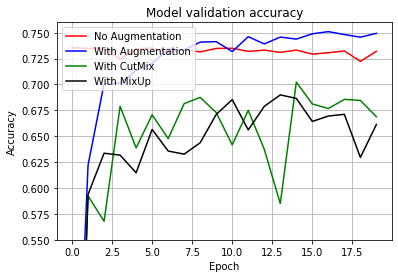

In [42]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cut['val_accuracy'], 'g')
plt.plot(history_resnet50_mix['val_accuracy'][:20], 'black')
# plt.plot(history_resnet50_nmix.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.grid(True) # Accuracy 범위 지정
plt.ylim(0.55, 0.76)
plt.show()

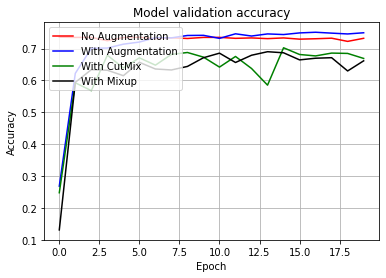

In [44]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cut['val_accuracy'], 'g')
plt.plot(history_resnet50_mix['val_accuracy'][:20], 'black')
#plt.plot(history_resnet50_nmix.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True) # Accuracy 범위 지정
#plt.ylim(0.72, 0.76)
plt.show()

epoch이 부족한가 생각되어 추가로 mixup 모델만 30 epoch 훈련을 진행했다.

model accuracy (mixup epoch 30)

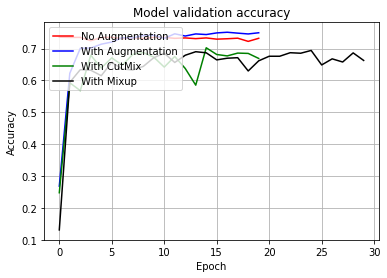

In [45]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cut['val_accuracy'], 'g')
plt.plot(history_resnet50_mix['val_accuracy'], 'black')  # 30 epochs
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True) # Accuracy 범위 지정
#plt.ylim(0.72, 0.76)
plt.show()

validation_loss

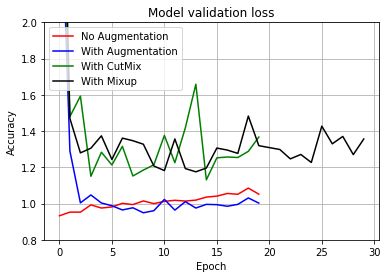

In [56]:
plt.plot(history_resnet50_no_aug['val_loss'], 'r')
plt.plot(history_resnet50_aug['val_loss'], 'b')
plt.plot(history_resnet50_cut['val_loss'], 'g')
plt.plot(history_resnet50_mix['val_loss'], 'black') # 30 epochs
plt.title('Model validation loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True) # Accuracy 범위 지정
plt.ylim(0.8, 2.0)
plt.show()

train_loss

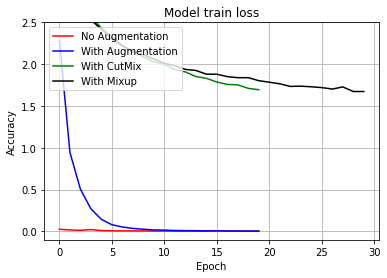

In [62]:
plt.plot(history_resnet50_no_aug['loss'], 'r')
plt.plot(history_resnet50_aug['loss'], 'b')
plt.plot(history_resnet50_cut['loss'], 'g')
plt.plot(history_resnet50_mix['loss'], 'black') # 30 epochs
plt.title('Model train loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True) # Accuracy 범위 지정
plt.ylim(-0.1, 2.5)
plt.show()

- 기본_cutmix, 기본_mixup이 적용된 모델의 경우 20 epoch을 진행했을 때 기본 augmentation 모델보다 성능이 떨어지는 결과를 보인다.

### 회고

- 기본 augmentation 모델의 경우 augmentation을 적용하지 않은 기본 모델보다 10epoch 이상 훈련을 진행했을 경우 더 높은 정확도를 보인다.
- 기본 augmentation에 cutmix, mixup을 적용할 경우 오히려 정확도가 더 떨어지는 결과를 보이며 epoch을 늘려도 성능이 더 개선되지는 않는 결과를 보였다.